In [1]:
cd ../utilities/

/home/gustav/Documents/DD142X/code/utilities


In [2]:
import numpy as np
from spectogram_script import load_all, epochs_as_rows
from plotting import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
freqs, dataDict = load_all()

In [4]:
animal, epochs = "NPR040.c12", {
    channel: values
    for channel, values in dataDict["NPR040.c12"].items()
}

In [5]:
channel_n = epochs[sorted(epochs.keys())[0]].shape[0]
print(channel_n)

776


In [6]:
fidx = ((freqs > 5) & (freqs < 50))
freqs = freqs[fidx]
epochs = {
    k: v[ : , fidx] for k, v in epochs.items() 
}
features_n = epochs[sorted(epochs.keys())[0]].shape[1]

In [7]:
channel = sorted(epochs.keys())[0]
values = epochs[channel]

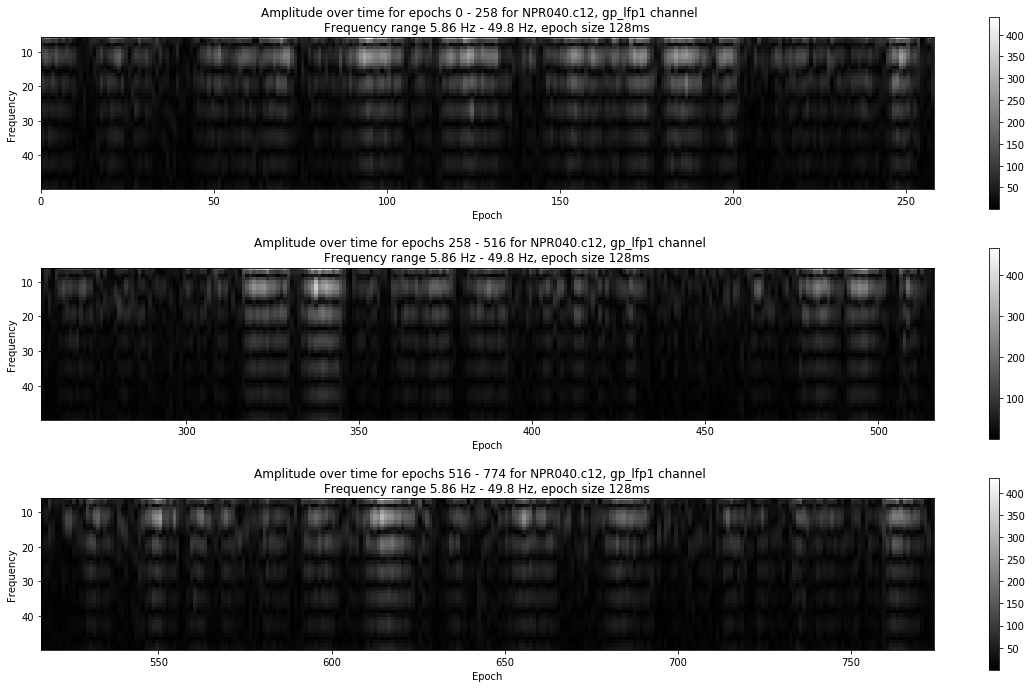

In [8]:
plt.figure(figsize = (20, 12))
maxn = 3
stepn = int(channel_n / maxn)
for step in range(0, maxn):
    
    lo = step * stepn
    hi = (step + 1) * stepn
    lof = round(np.min(freqs), 2)
    hif = round(np.max(freqs), 2)

    plt.subplot(maxn, 1, step + 1)
    plt.title(f"Amplitude over time for epochs {lo} - {hi} for {animal}, {channel} channel\
    \nFrequency range {lof} Hz - {hif} Hz, epoch size 128ms")
    plt.xlabel("Epoch")
    plt.ylabel("Frequency")
    plt.imshow(
        values.transpose()[ : , lo : hi],
        cmap = 'gray',
        extent = [
            lo, hi, hif, lof
        ]
    )
    plt.colorbar()
    
plt.savefig("../_data/FFV-KMeans/FFV.png")
plt.show()

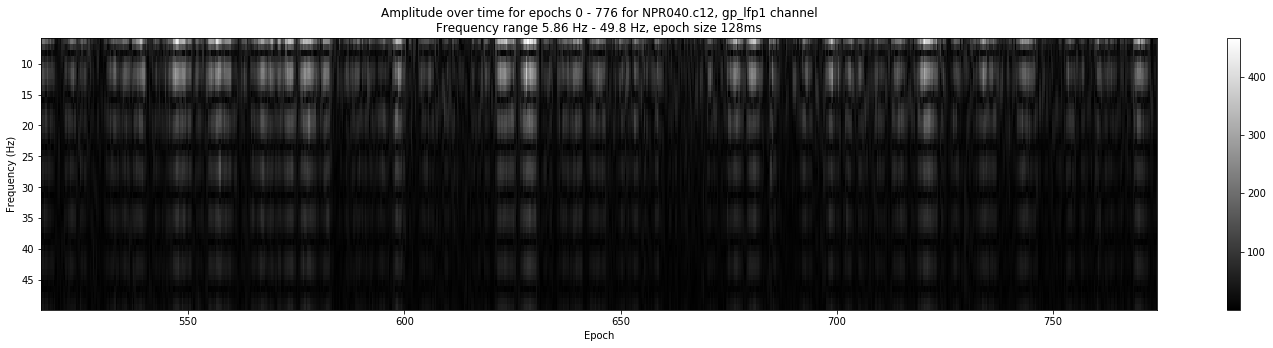

In [10]:
plt.figure(figsize = (25, 5))
plt.title(f"Amplitude over time for epochs 0 - {channel_n} for {animal}, {channel} channel" + \
    f"\nFrequency range {lof} Hz - {hif} Hz, epoch size 128ms")
plt.xlabel("Epoch")
plt.ylabel("Frequency (Hz)")
plt.imshow(
    values.transpose(),
    cmap = 'gray',
    extent = [
        lo, hi, hif, lof
    ],
    aspect = 'auto'
)
plt.colorbar()
plt.savefig("../_data/FFV-KMeans/exampleSpect.png")
plt.show()

In [56]:
epochs_all = np.concatenate([
    v for _, v in epochs.items()
], axis = 0)
print(epochs_all.shape)

(24832, 46)


In [57]:
from sklearn.cluster import KMeans

In [72]:
for k in [2, 4, 8, 16, 32]:
    kmeans_model = KMeans(n_clusters = k).fit(epochs_all.copy())
    predictions = kmeans_model.predict(epochs_all).reshape((-1, channel_n))
    plt.figure(figsize = (20, 14))
    maxn = 3
    stepn = int(channel_n / maxn)
    for step in range(0, maxn):

        lo = step * stepn
        hi = (step + 1) * stepn

        plt.subplot(maxn, 1, step + 1)
        plt.title(f"{k}-KMeans prediction per-channel over time for epochs {lo} - {hi} for {animal}\
        \nFrequency range {lof} Hz - {hif} Hz, epoch size 128ms")
        plt.xlabel("Epoch")
        plt.ylabel("Channel")
        plt.imshow(
            predictions[ : , lo : hi],
            cmap = 'gray',
            extent = [
                lo, hi, hif, lof
            ]
        )

    plt.savefig(f"../_data/FFV-KMeans/KMeans{k}.png")
    plt.close()